### Imports

In [58]:
from main import QuantumIR
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
import numpy as np

### Generate the IR

In [68]:
# Run
quantum_ir = QuantumIR();
quantum_ir.run_dataclass();
quantum_ir.run_generate_ir();
quantum_ir.run_transformations();


IR:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1, %q2_0 : i1):
    %q0_1 = "quantum.not"(%q0_0) : (i1) -> i1
    %q3_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q3_1 = "quantum.cnot"(%q0_1, %q3_0) : (i1, i1) -> i1
    %q3_2 = "quantum.cnot"(%q1_0, %q3_1) : (i1, i1) -> i1
    %q3_3 = "quantum.cnot"(%q2_0, %q3_2) : (i1, i1) -> i1
    %q3_4 = "quantum.measure"(%q3_3) : (i1) -> i1
  }) {"func_name" = "xorInPlace"} : () -> ()
}

Transformations:


Inplacing
builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1, %q2_0 : i1):
    %q0_1 = "quantum.not"(%q0_0) : (i1) -> i1
    %q0_2 = "quantum.cnot"(%q1_0, %q0_1) : (i1, i1) -> i1
    %q0_3 = "quantum.cnot"(%q2_0, %q0_2) : (i1, i1) -> i1
    %q3_4 = "quantum.measure"(%q0_3) : (i1) -> i1
  }) {"func_name" = "xorInPlace"} : () -> ()
}

No more transformations possible


Final IR:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1, %q2_0 : i1):
    %q0_1 = "quantum.not"(%

### Find input and output number

In [69]:
module = quantum_ir.module
funcOp = module.body.block._first_op

# Numbers and type of the input parameters
input_args = funcOp.body.block._args
input_number = input_args.__len__()
input_types = [arg.type for arg in input_args]

# First and last op
first_op = funcOp.body.block._first_op
last_op = funcOp.body.block._last_op
output_number = 0

current = first_op
while(current is not None):
    if current.name == "quantum.init":
        input_number += 1
    if current.name == "quantum.measure":
        output_number += 1
    current = current.next_op

print("Number of inputs: ", input_number, "Number of outputs: ",output_number)

Number of inputs:  3 Number of outputs:  1


### Initialize circuit

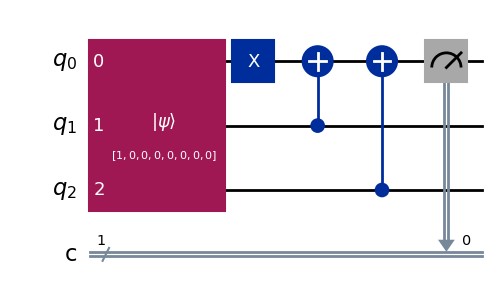

In [70]:

def create_circuit(first_op, input_number, output_number,state):

    circuit = QuantumCircuit(input_number,output_number)
    current = first_op
    cbit_index = 0

    qubit_list = [i for i in range(input_number)]

    circuit.initialize(state,qubit_list)

    while(current is not None):
        # find the indexes of the qubit
        operands_names = [op._name for op in current.operands]
        indexes = [int(name.split("_")[0][1]) for name in operands_names]
        if current.name  == "quantum.cnot":
            circuit.cx(indexes[0],indexes[1])
        if current.name == "quantum.ccnot":
            circuit.ccx(indexes[0],indexes[1],indexes[2])
        if current.name == "quantum.not":
            circuit.x(indexes[0])
        if current.name == "quantum.measure":
            circuit.measure(indexes[0],cbit_index)
            cbit_index+=1
        
        current = current.next_op
    
    return circuit

# initializing it to an example state (e.g. all qubit at 0)
example_state = np.array([1] + [0] * (2**input_number - 1))
create_circuit(first_op, input_number, output_number,example_state).draw(output='mpl')



### Input initilization

In [71]:
from numpy import eye

istates = eye(2**input_number);

def bit_strings_iterative(N):
    bit_list = ['']
    for _ in range(N):
        bit_list = ['0' + bit_string for bit_string in bit_list] + \
                   ['1' + bit_string for bit_string in bit_list]
    return bit_list

# tutte le stringhe di bit di input_number bit
istr = bit_strings_iterative(input_number)

print(istr)
print(istates)

['000', '001', '010', '011', '100', '101', '110', '111']
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [72]:
from qiskit.providers import JobStatus

counts = {}
backend = AerSimulator()
qubit_list = [i for i in range(input_number)]

for i in range(istates.shape[1]):
    circuit=create_circuit(first_op, input_number, output_number,istates[i])

    job = backend.run(circuit, shots=2000)
    result = job.result()
    
    counts[istr[i]] = result.get_counts()

counts

{'000': {'1': 2000},
 '001': {'0': 2000},
 '010': {'0': 2000},
 '011': {'1': 2000},
 '100': {'0': 2000},
 '101': {'1': 2000},
 '110': {'1': 2000},
 '111': {'0': 2000}}

# Metriche
numero di qubit, numero di gate, depth (percorso critico)